<a href="https://colab.research.google.com/github/Su-ok/MT2025124_ML_Project2/blob/main/BinSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import pandas as pd
# import numpy as np

# from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.svm import LinearSVC

# import warnings
# warnings.filterwarnings("ignore")

# np.random.seed(42)

# # ==== LOAD DATA ====
# train = pd.read_csv("/content/drive/MyDrive/ML kaggle data/smoker/train_dataset.csv")
# test  = pd.read_csv("/content/drive/MyDrive/ML kaggle data/smoker/test_dataset.csv")

# print("Train shape:", train.shape)
# print("Test shape:", test.shape)
# print(train.columns)   # <-- IMPORTANT: Check column names

# # ==== BASIC PREPROCESSING ====
# # Only drop target now (NO 'id')
# X = train.drop("smoking", axis=1)
# y = train["smoking"]

# # ==== SCALING ====
# scaler = StandardScaler()
# X_scaled    = scaler.fit_transform(X)
# test_scaled = scaler.transform(test)   # NO id dropped

# # ==== TRAIN / VALIDATION SPLIT ====
# X_train, X_val, y_train, y_val = train_test_split(
#     X_scaled,
#     y,
#     test_size=0.2,
#     random_state=42,
#     stratify=y
# )

# print("X_train:", X_train.shape, "X_val:", X_val.shape)

# # ==== DEFINE LINEAR SVM ====
# base_svm = LinearSVC()

# param_dist = {
#     "C": [0.01, 0.1, 1.0, 10.0],
#     "loss": ["hinge", "squared_hinge"],
#     "max_iter": [2000, 5000]
# }

# cv_strat = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# svm_search = RandomizedSearchCV(
#     estimator=base_svm,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring="accuracy",
#     n_jobs=-1,
#     cv=cv_strat,
#     random_state=42,
#     verbose=2
# )

# svm_search.fit(X_train, y_train)

# print("Best Parameters Found:")
# print(svm_search.best_params_)
# print(f"Best CV Accuracy: {svm_search.best_score_:.6f}")

# # ==== EVALUATION ====
# best_svm = svm_search.best_estimator_

# y_train_pred = best_svm.predict(X_train)
# y_val_pred   = best_svm.predict(X_val)

# train_acc = accuracy_score(y_train, y_train_pred)
# val_acc   = accuracy_score(y_val, y_val_pred)

# print(f"\nTraining Accuracy (SVM):   {train_acc:.6f}")
# print(f"Validation Accuracy (SVM): {val_acc:.6f}")

# print("\nClassification Report:")
# print(classification_report(y_val, y_val_pred))

# print("\nConfusion Matrix:")
# print(confusion_matrix(y_val, y_val_pred))

# # ==== FINAL TRAINING & SUBMISSION ====
# full_svm = LinearSVC(
#     C=svm_search.best_params_["C"],
#     loss=svm_search.best_params_["loss"],
#     max_iter=svm_search.best_params_["max_iter"]
# )

# full_svm.fit(X_scaled, y)
# test_preds = full_svm.predict(test_scaled)

# submission_binary = pd.DataFrame({
#     "smoking": test_preds   # NO id column used
# })

# submission_binary.to_csv("submission_svm_smoker.csv", index=False)
# print("\nsubmission_svm_smoker.csv created successfully.")

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==== LOAD DATA ====
train_path = "/content/drive/MyDrive/ML kaggle data/smoker/train_dataset.csv"
test_path  = "/content/drive/MyDrive/ML kaggle data/smoker/test_dataset.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Original train shape:", train.shape)

# Identify feature columns
target_col = "smoking"
feature_cols = [c for c in train.columns if c != target_col]

# ==== 1) DETECT DUPLICATES ====
exact_dup_mask = train.duplicated(subset=feature_cols + [target_col], keep=False)
feat_dup_mask = train.duplicated(subset=feature_cols, keep=False)

print("Exact duplicates:", exact_dup_mask.sum())
print("Feature duplicates:", feat_dup_mask.sum())

# ==== 2) RESOLVE DUPLICATES ====
grouped = train.groupby(feature_cols)[target_col].agg(
    n_samples='size',
    unique_labels=lambda s: s.unique().tolist(),
    label_counts=lambda s: s.value_counts().to_dict()
).reset_index()

rows = []
resolved_by_majority = 0
removed_ties = 0

for _, row in grouped.iterrows():
    feat_vals = {c: row[c] for c in feature_cols}
    labels = row["unique_labels"]
    counts = row["label_counts"]

    if len(labels) == 1:
        # pure group → keep one row
        rows.append({**feat_vals, target_col: labels[0]})

    else:
        # conflicting labels → majority vote if unique
        max_count = max(counts.values())
        majority_labels = [lbl for lbl, cnt in counts.items() if cnt == max_count]

        if len(majority_labels) == 1:
            rows.append({**feat_vals, target_col: majority_labels[0]})
            resolved_by_majority += 1
        else:
            # unresolved conflict → drop group
            removed_ties += row["n_samples"]

print("Resolved by majority:", resolved_by_majority)
print("Removed ambiguous groups:", removed_ties)

clean_train = pd.DataFrame(rows)
print("Cleaned train shape:", clean_train.shape)

# ==== 3) PREPARE DATA ====
X = clean_train[feature_cols].values
y = clean_train[target_col].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

test_scaled = scaler.transform(test[feature_cols].values)

# ==== 4) TRAIN / VALIDATION SPLIT ====
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)

svc = SVC(kernel="rbf", class_weight="balanced", probability=False, random_state=42)

param_dist = {
    "C": [0.01, 0.1, 1.0],
    "gamma": [0.001, 0.01, 'scale']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_dist,
    scoring="accuracy",
    n_jobs=-1,
    cv=cv,
    verbose=2
)

print("\n=== Starting GridSearchCV ===")
grid_search.fit(X_train, y_train)

print("\nBest params:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

best_svc = grid_search.best_estimator_

# ==== 6) EVALUATION ====
y_train_pred = best_svc.predict(X_train)
y_val_pred   = best_svc.predict(X_val)

print("\nTrain accuracy:", accuracy_score(y_train, y_train_pred))
print("Val accuracy:", accuracy_score(y_val, y_val_pred))

# print("\nClassification report:")
# print(classification_report(y_val, y_val_pred))

# print("\nConfusion matrix:")
# print(confusion_matrix(y_val, y_val_pred))

# ==== 7) FINAL TRAINING & SUBMISSION ====
best_svc.fit(X_scaled, y)
test_preds = best_svc.predict(test_scaled)

submission = pd.DataFrame({"smoking": test_preds})
submission.to_csv("submission_svm_smoker_rbf.csv", index=False)

print("\nSaved submission_svm_smoker_rbf.csv")

Original train shape: (38984, 23)
Exact duplicates: 11034
Feature duplicates: 11034
Resolved by majority: 0
Removed ambiguous groups: 0
Cleaned train shape: (33467, 23)
X_train: (26773, 22) X_val: (6694, 22)

=== Starting GridSearchCV ===
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best params: {'C': 1.0, 'gamma': 'scale'}
Best CV accuracy: 0.713554819806303

Train accuracy: 0.7362641467149741
Val accuracy: 0.7234837167612788

Saved submission_svm_smoker_rbf.csv


In [ ]:
print("\nClassification report:")
print(classification_report(y_val, y_val_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_val, y_val_pred))


Classification report:
              precision    recall  f1-score   support

           0       0.90      0.64      0.74      4242
           1       0.58      0.87      0.70      2452

    accuracy                           0.72      6694
   macro avg       0.74      0.76      0.72      6694
weighted avg       0.78      0.72      0.73      6694


Confusion matrix:
[[2698 1544]
 [ 307 2145]]


EDA

In [ ]:
## 1. Basic overview
print("\nColumns:", clean_train.columns.tolist())

print("\nData types:")
print(clean_train.dtypes)

print("\nMissing values per column:")
print(clean_train.isnull().sum())


Columns: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking']

Data types:
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental cari

In [ ]:
## 2. Summary Statistics
print("\nSummary statistics:")
print(clean_train.describe())


Summary statistics:
                age    height(cm)    weight(kg)     waist(cm)  eyesight(left)  \
count  33467.000000  33467.000000  33467.000000  33467.000000    33467.000000   
mean      44.153943    164.684465     65.930319     82.081501        1.013849   
std       12.071768      9.195867     12.877955      9.310533        0.496245   
min       20.000000    130.000000     30.000000     51.000000        0.100000   
25%       40.000000    160.000000     55.000000     76.000000        0.800000   
50%       40.000000    165.000000     65.000000     82.000000        1.000000   
75%       55.000000    170.000000     75.000000     88.000000        1.200000   
max       85.000000    190.000000    135.000000    129.000000        9.900000   

       eyesight(right)  hearing(left)  hearing(right)      systolic  \
count     33467.000000   33467.000000    33467.000000  33467.000000   
mean          1.009553       1.025368        1.026056    121.498730   
std           0.497867       0.15724

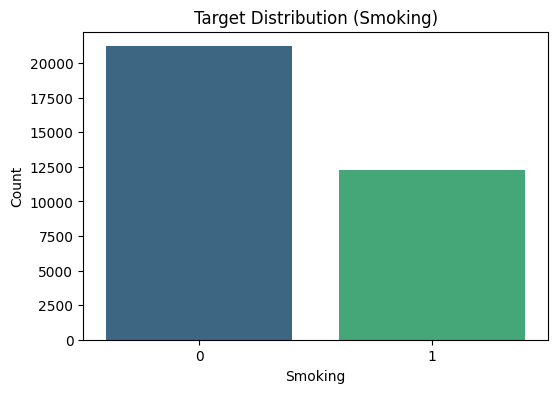


Class distribution (%):
smoking
0    63.372875
1    36.627125
Name: proportion, dtype: float64


In [ ]:
## 3. Target Variable Distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x="smoking", data=clean_train, palette="viridis")
plt.title("Target Distribution (Smoking)")
plt.xlabel("Smoking")
plt.ylabel("Count")
plt.show()

print("\nClass distribution (%):")
print(clean_train["smoking"].value_counts(normalize=True)*100)

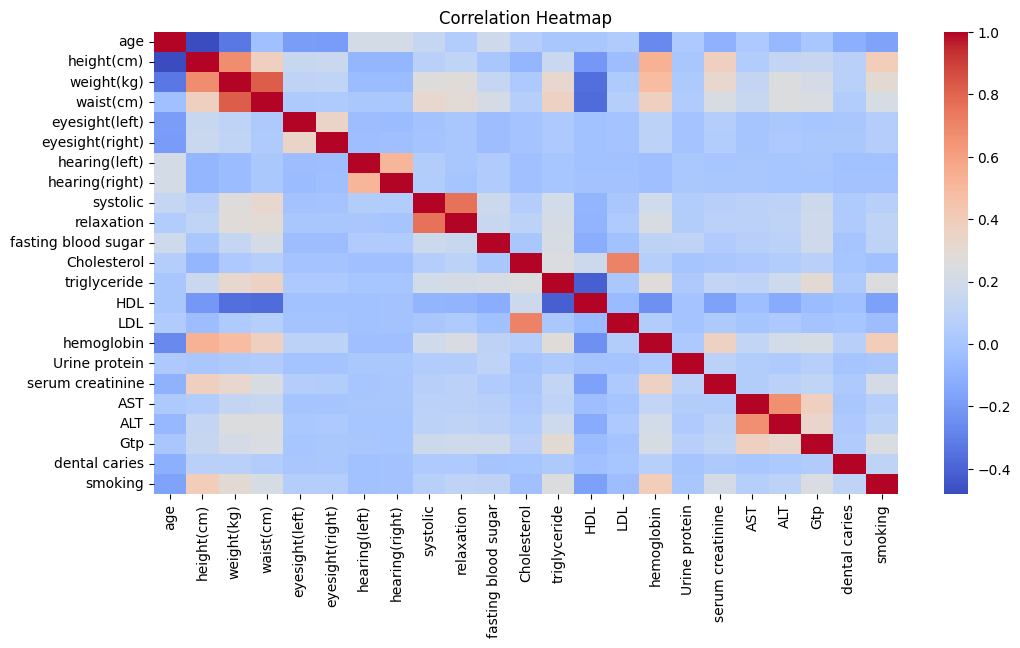


Top correlations with smoking:
smoking                1.000000
hemoglobin             0.398321
height(cm)             0.393353
weight(kg)             0.298142
triglyceride           0.249482
Gtp                    0.238014
waist(cm)              0.222772
serum creatinine       0.209042
dental caries          0.106387
relaxation             0.104472
fasting blood sugar    0.097833
ALT                    0.097347
systolic               0.070407
AST                    0.063507
eyesight(right)        0.061988
eyesight(left)         0.060057
Urine protein          0.013432
hearing(right)        -0.018060
hearing(left)         -0.023257
Cholesterol           -0.029580
LDL                   -0.041953
age                   -0.167149
HDL                   -0.177394
Name: smoking, dtype: float64


In [ ]:
## 4. Correlation heatmap (numeric features)
plt.figure(figsize=(12,6))
corr = clean_train.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Show top correlations with target
corr_target = corr["smoking"].sort_values(ascending=False)
print("\nTop correlations with smoking:")
print(corr_target)

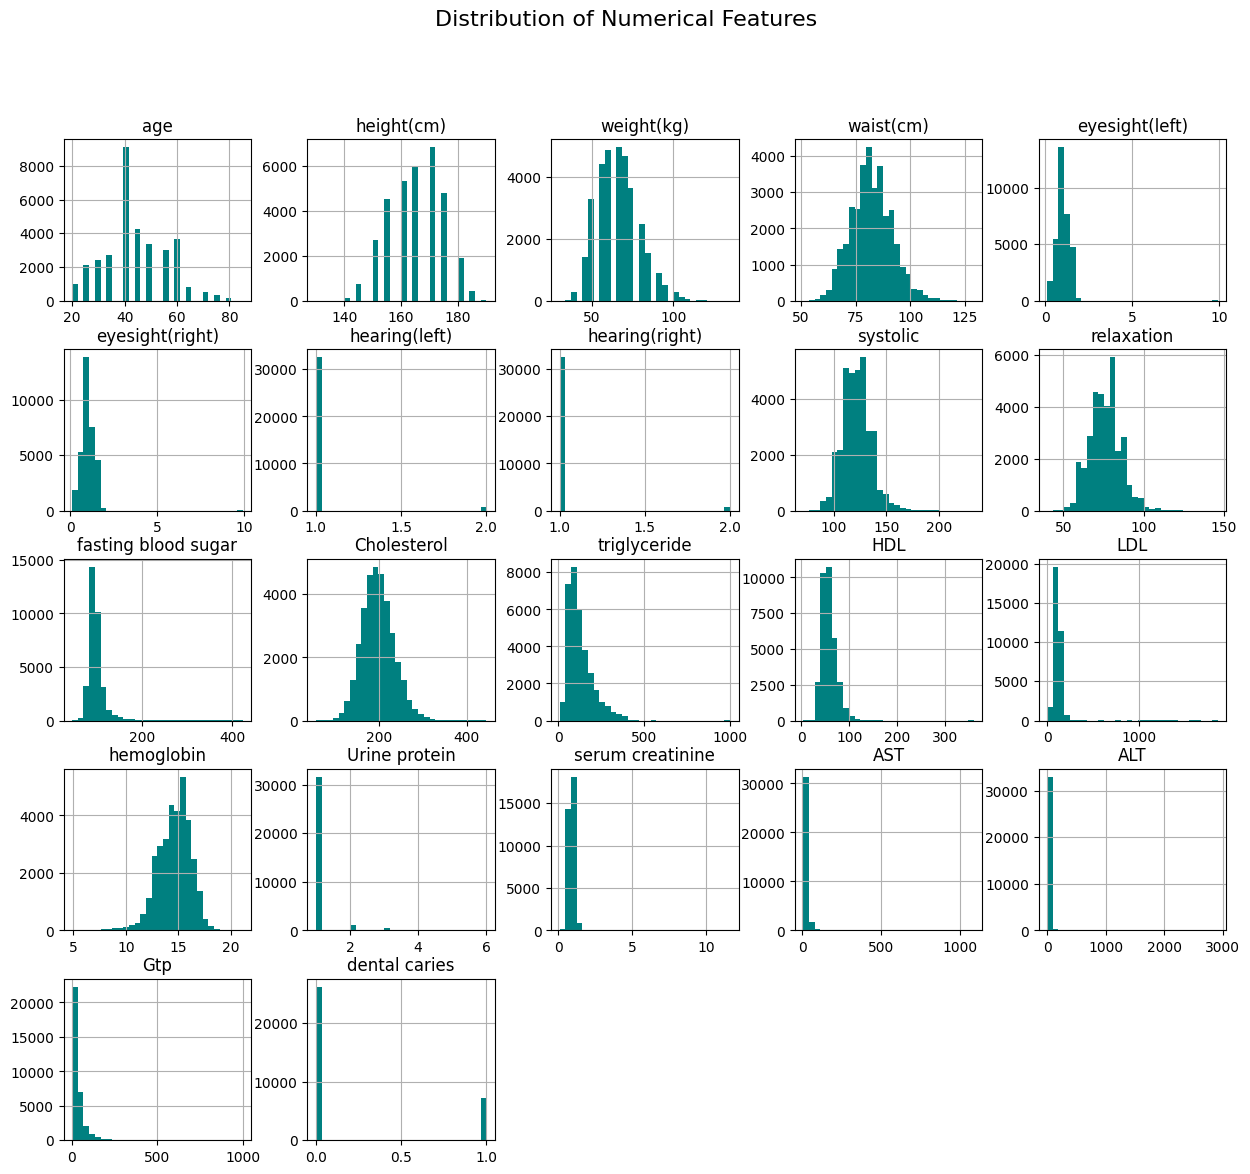

In [ ]:
## 5. Distribution plots of numerical features
num_cols = clean_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("smoking")  # exclude target

clean_train[num_cols].hist(bins=30, figsize=(15,13), color="teal")
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

In [ ]:
## 6. Outlier detection (Z-score method)
from scipy import stats

z_scores = np.abs(stats.zscore(clean_train[num_cols]))
outliers = (z_scores > 3).sum(axis=0)

print("\nOutlier count per feature (|z| > 3):")
print(outliers)


Outlier count per feature (|z| > 3):
[ 13   5 249 128  59  60 849 872 204 193 603 168 542 290  52 323 776  87
 297 240 533   0]


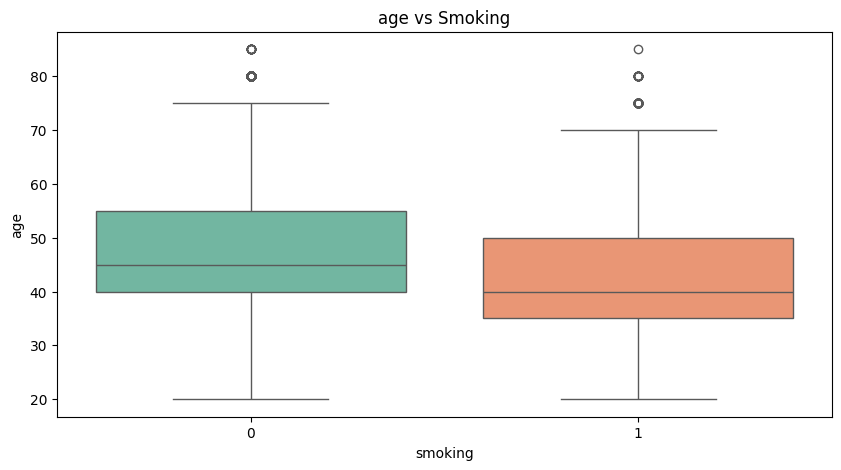

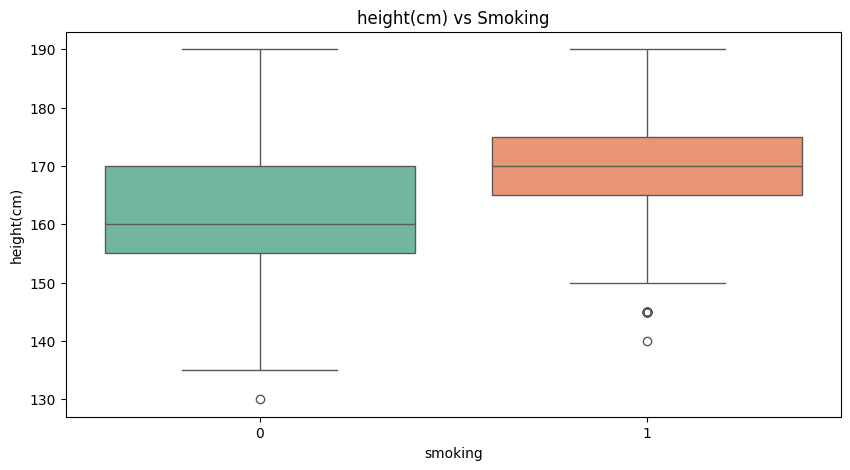

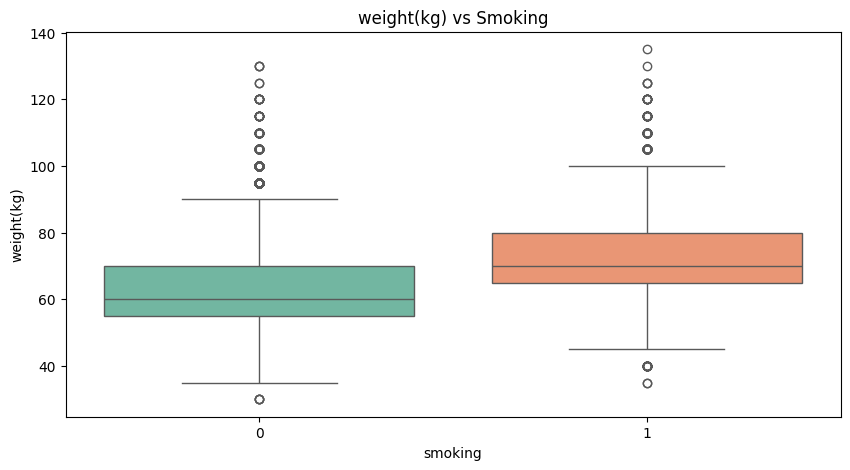

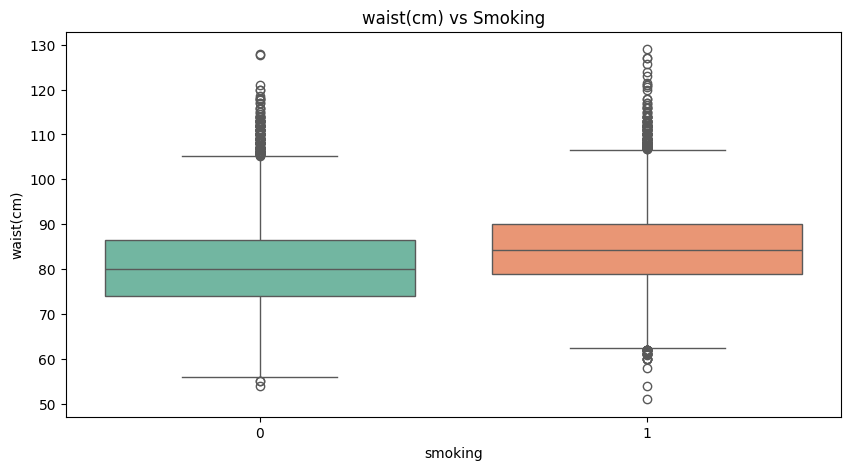

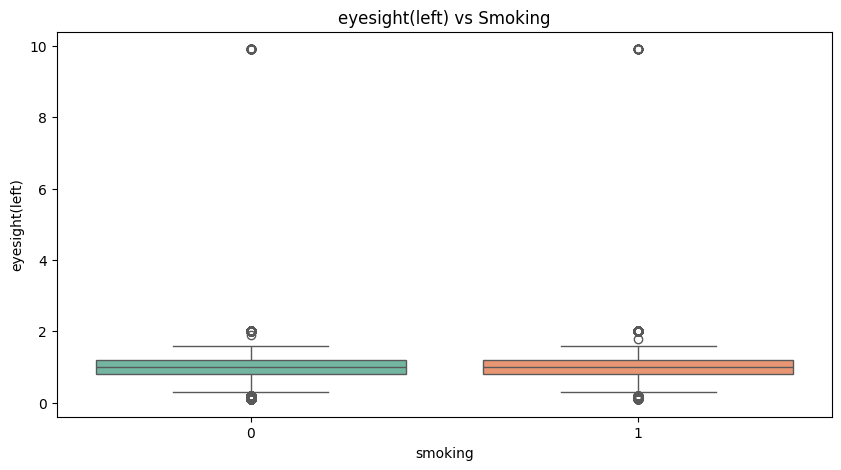

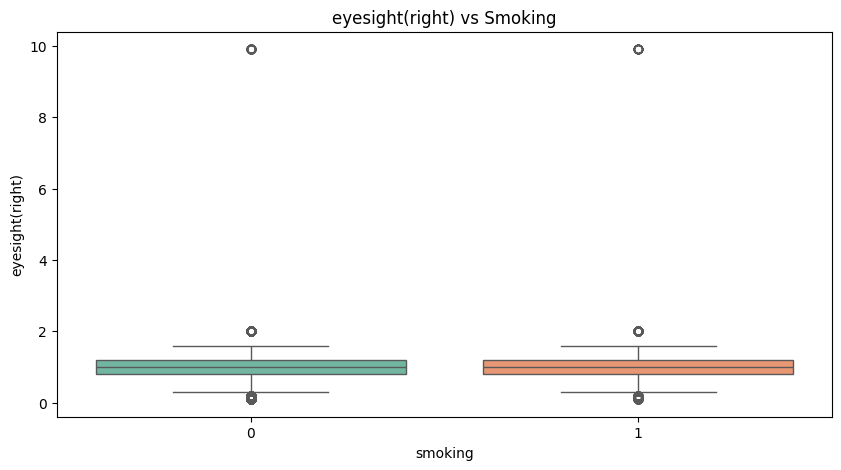

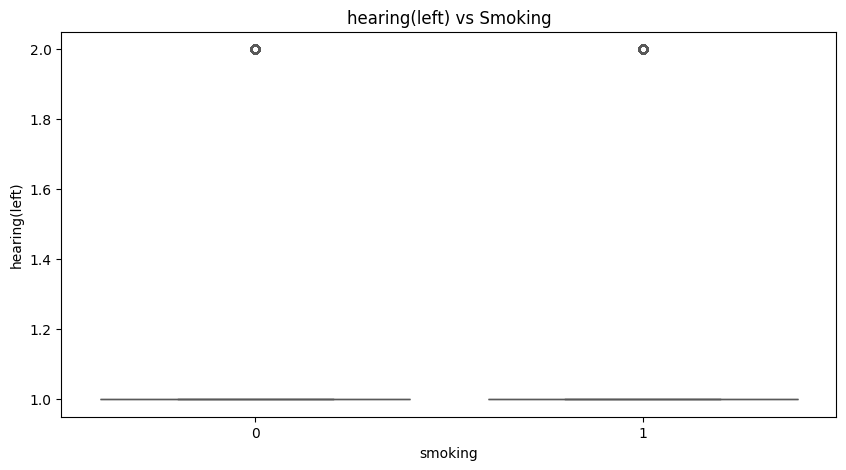

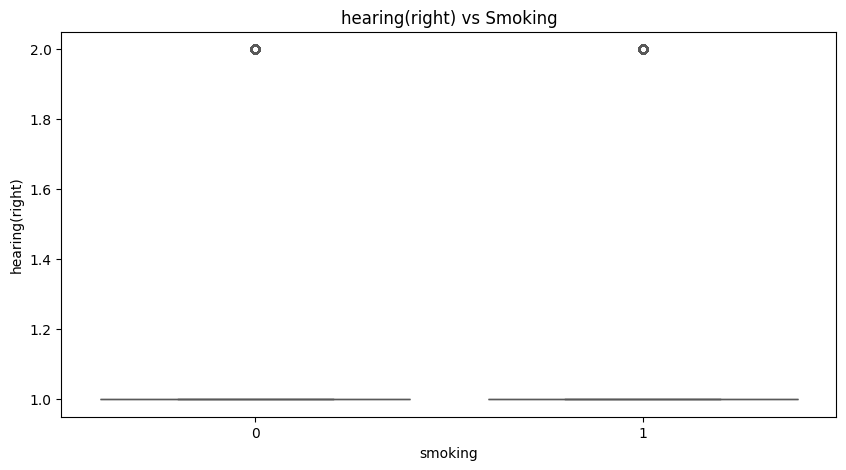

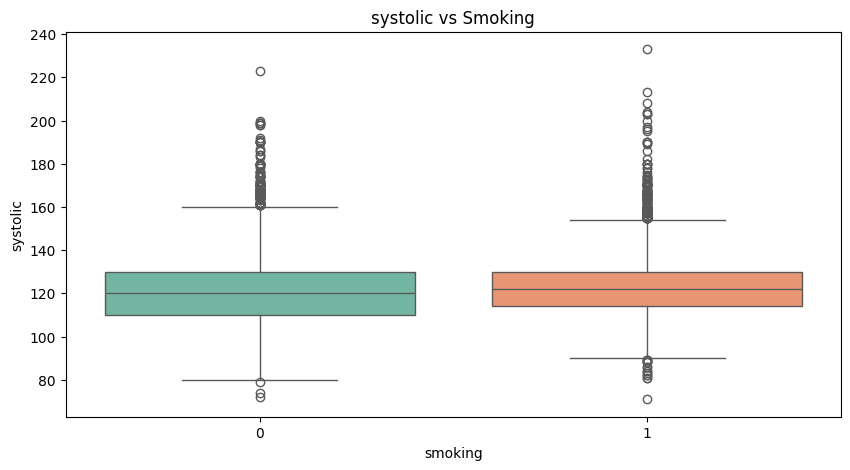

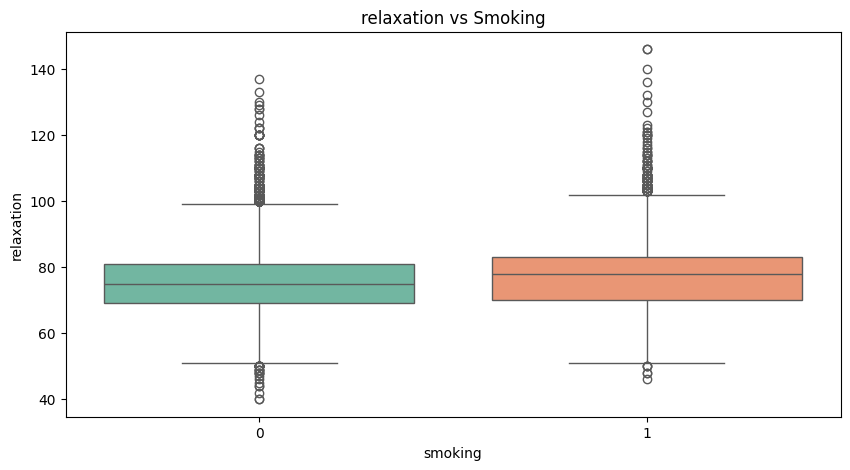

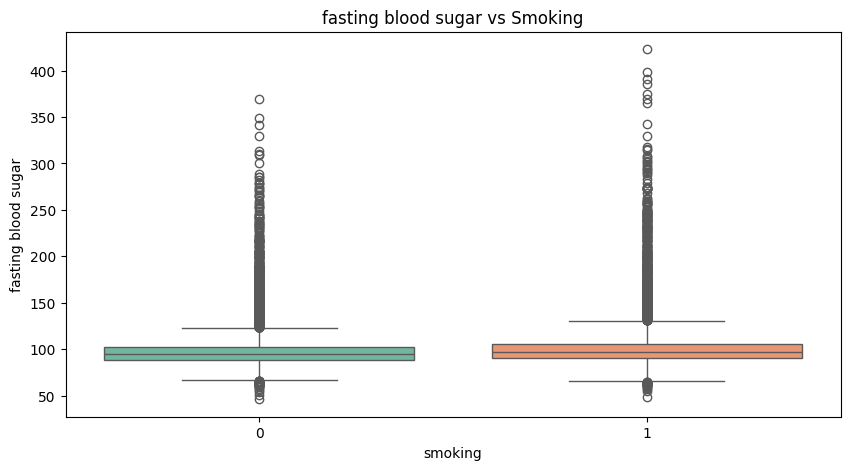

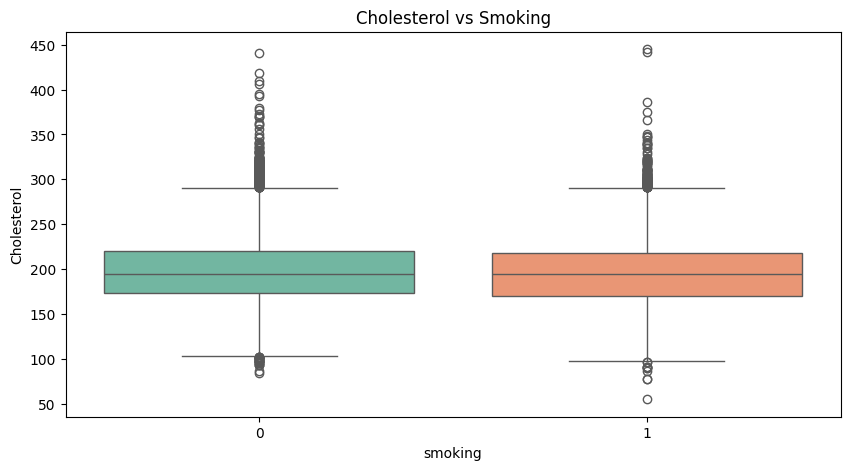

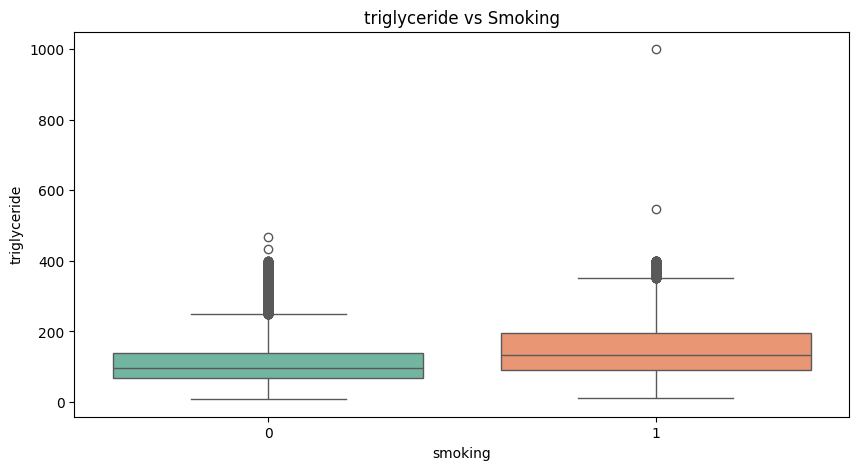

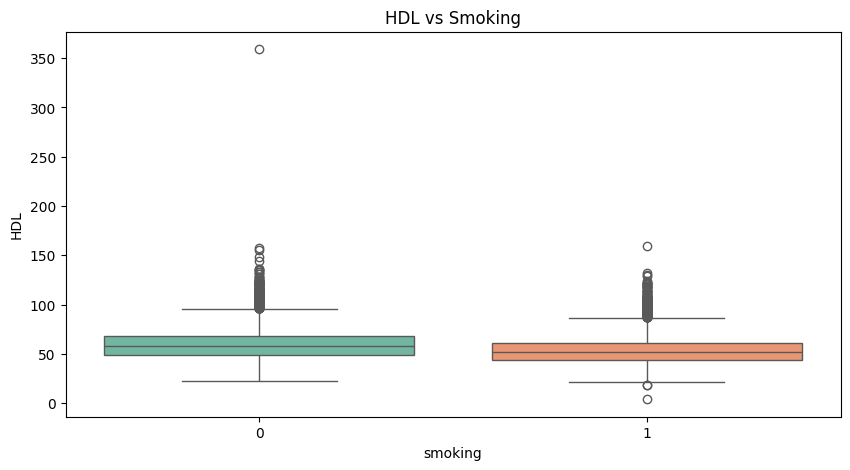

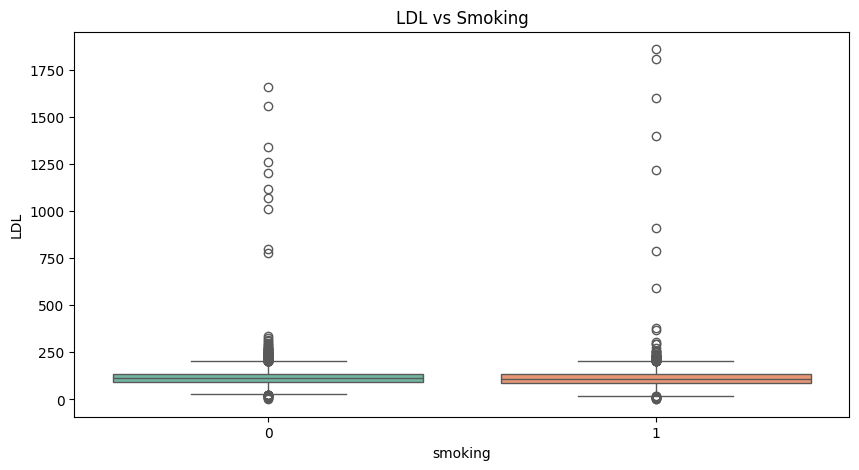

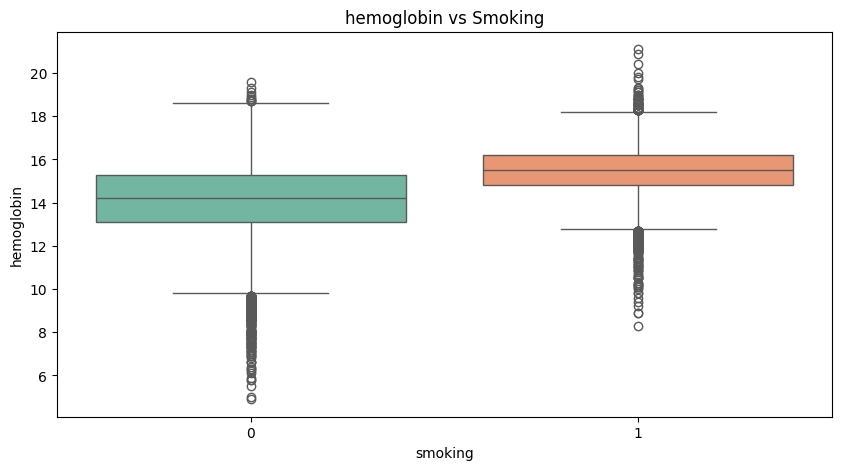

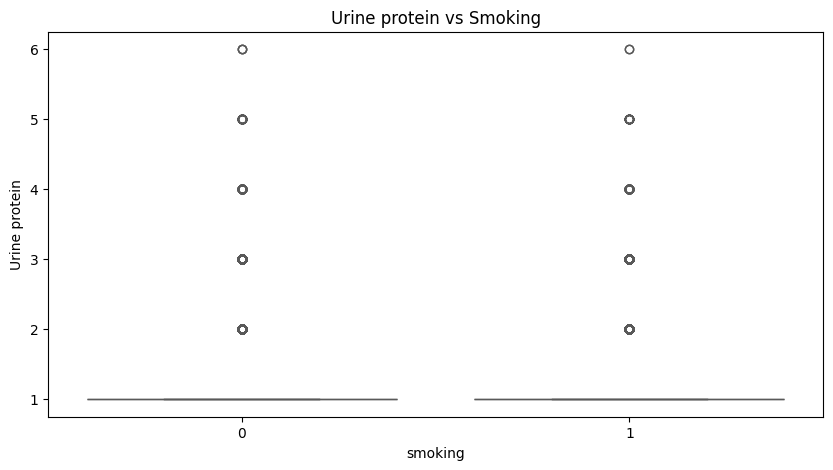

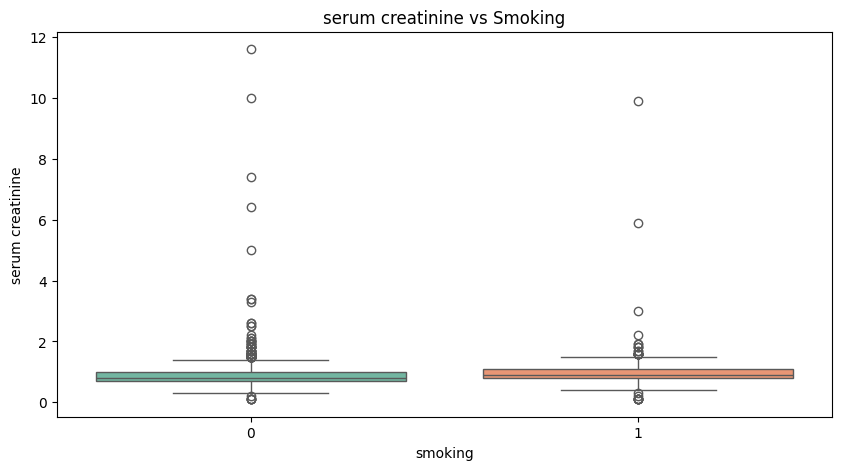

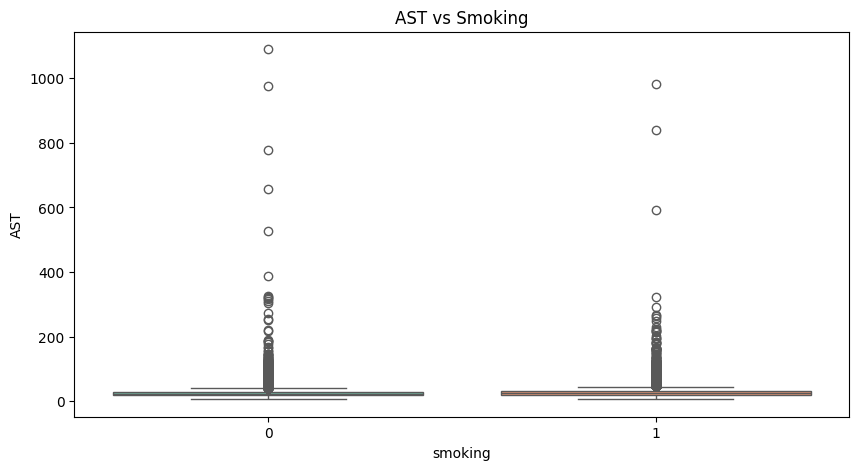

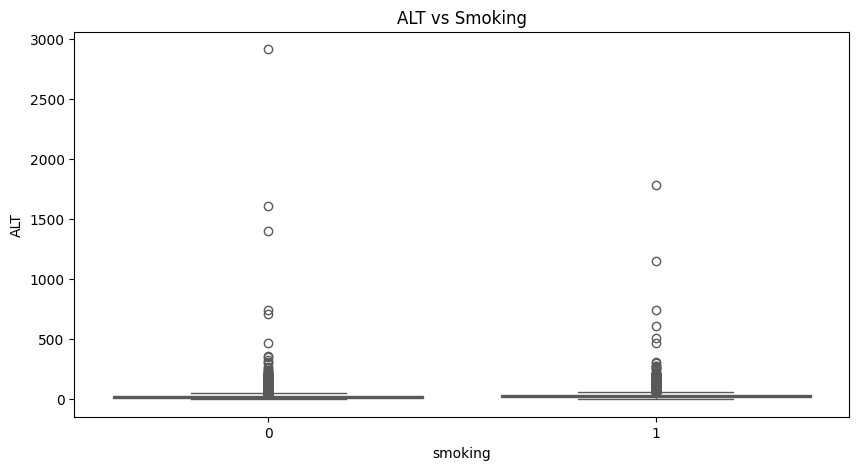

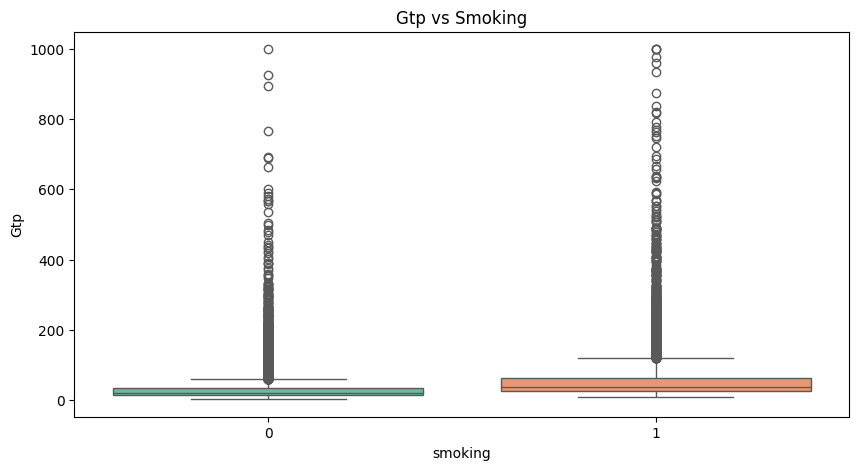

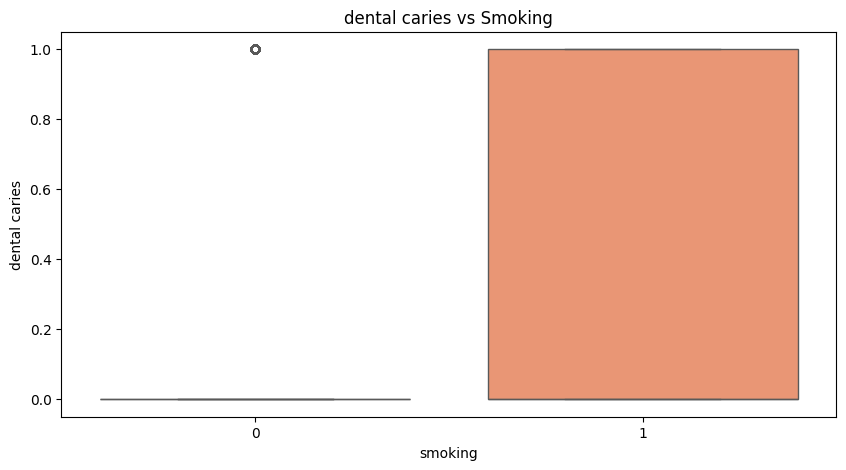

In [ ]:
## 7. Relationship between each feature and target (boxplots)
for col in num_cols:
    plt.figure(figsize=(10,5))
    sns.boxplot(x="smoking", y=col, data=clean_train, palette="Set2")
    plt.title(f"{col} vs Smoking")
    plt.show()